In [140]:
# Import des librairies essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

df_fe = pd.read_csv(r"C:\Users\meria\Downloads\mlProject\eng_data.csv")
df_ready = pd.read_csv(r"C:\Users\meria\Downloads\mlProject\prepared_data.csv")
X_prepared = np.load(r"C:\Users\meria\Downloads\mlProject\X_prepared.npy")

print("df_ready shape:", df_ready.shape)
display(df_ready.head(5))
print("X_prepared shape:", X_prepared.shape)


df_ready shape: (30000, 665)


,Median_Salary_USD,Experience_Required_Years,Job_Openings_2024,Projected_Openings_2030,Remote_Work_Ratio_%,Automation_Risk_%,Gender_Diversity_%,Education_Num,AI_Impact_Num,Job_Status_Num,...,Job_Status_Increasing,AI_Impact_Level_Low,AI_Impact_Level_Moderate,Location_Brazil,Location_Canada,Location_China,Location_Germany,Location_India,Location_UK,Location_USA
0,-1.395182,-0.833491,-1.231978,0.442275,0.211404,-0.760726,-0.309688,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.225715,0.816517,-1.327050,0.394481,-1.140171,1.375642,0.949982,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.544813,-0.998491,-0.594779,-1.367596,1.449398,0.793470,-0.512300,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.216677,0.816517,0.745679,-0.353817,-1.655254,1.731413,0.913511,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.847490,0.486516,0.316103,0.809970,0.135453,-0.434863,1.307737,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


X_prepared shape: (30000, 665)


In [141]:
# ===== PCA =====
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df_ready.select_dtypes(include=[np.number]))
print("Nombre de composantes conservées :", X_pca.shape[1])


Nombre de composantes conservées : 299


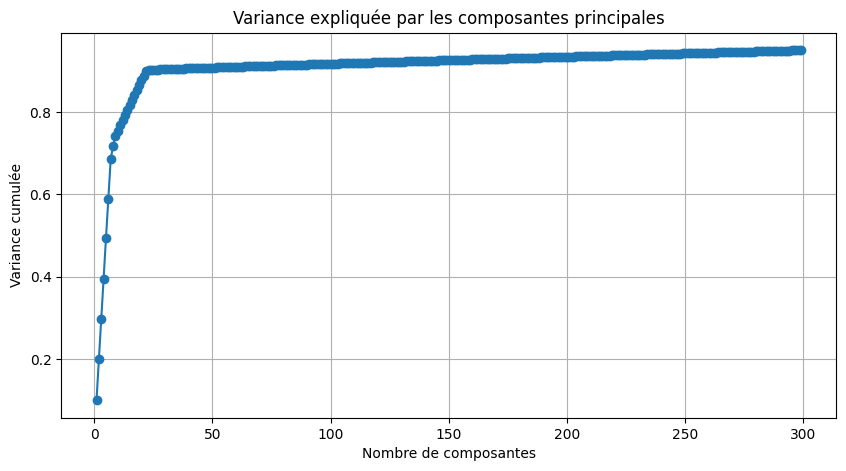

In [142]:
# Variance expliquée 
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Variance expliquée par les composantes principales')
plt.grid(True)
plt.show()


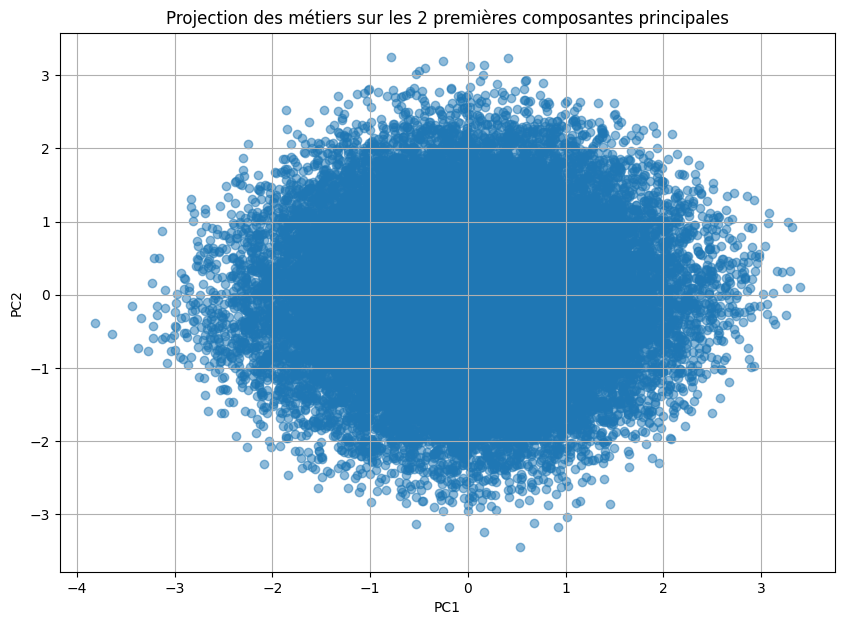

In [143]:
plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection des métiers sur les 2 premières composantes principales')
plt.grid(True)
plt.show()

In [144]:
# Contribution des features à la PC1 et PC2
pca_features = pd.DataFrame(pca.components_[:2], columns=df_ready.columns, index=['PC1','PC2']).T
pca_features.sort_values(by='PC1', ascending=False).head(10)  # top 10 features PC1


,PC1,PC2
Gender_Diversity_%,0.492227,-0.567178
Median_Salary_USD,0.471717,-0.193009
Automation_Risk_%,0.447510,0.396536
Projected_Openings_2030,0.411850,-0.097999
Remote_Work_Ratio_%,0.308757,0.253954
Experience_Required_Years,0.259839,0.622697
Job_Openings_2024,0.048097,-0.147627
Job_Status_Increasing,0.003951,0.005381
AI_Impact_Level_Moderate,0.003493,0.005342
Location_Brazil,0.003383,0.000940


C:\Users\meria\AppData\Local\Temp\ipykernel_1868\2559687612.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


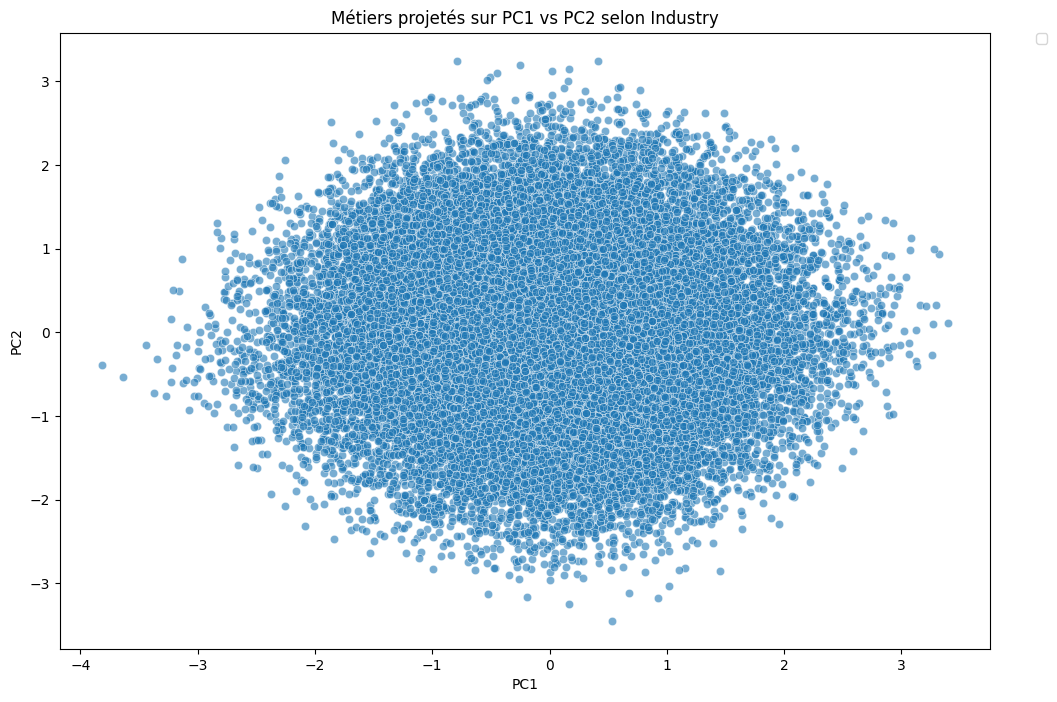

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
# Réduire les 6 features à 2 composantes pour la visualisation
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], 
             alpha=0.6, palette='Set2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Métiers projetés sur PC1 vs PC2 selon Industry')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


# **clustering** 

**DBSCAN**

In [146]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [147]:
X_country = df_fe[['Job_Growth_Rate_%', 'Automation_Risk_%', 'Median_Salary_USD']]


In [148]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_country)


In [149]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
df_fe['DBSCAN_Country_Cluster'] = dbscan.fit_predict(X_scaled)


In [150]:
# Moyenne de Job_Growth_Rate par cluster et par pays
country_summary = df_fe.groupby(['Location', 'DBSCAN_Country_Cluster'])['Job_Growth_Rate_%'].mean()
print(country_summary.sort_values(ascending=False))


Location   DBSCAN_Country_Cluster
Canada     -1                        8945.098039
Brazil     -1                        8505.769231
UK         -1                        8219.000000
India      -1                        8171.631408
China      -1                        8148.509434
Australia   0                         146.633155
Brazil      0                         143.516858
China       0                         142.720580
USA         0                         141.899924
India       0                         138.961402
Germany     0                         138.212545
Canada      0                         137.153955
UK          0                         117.611629
Name: Job_Growth_Rate_%, dtype: float64


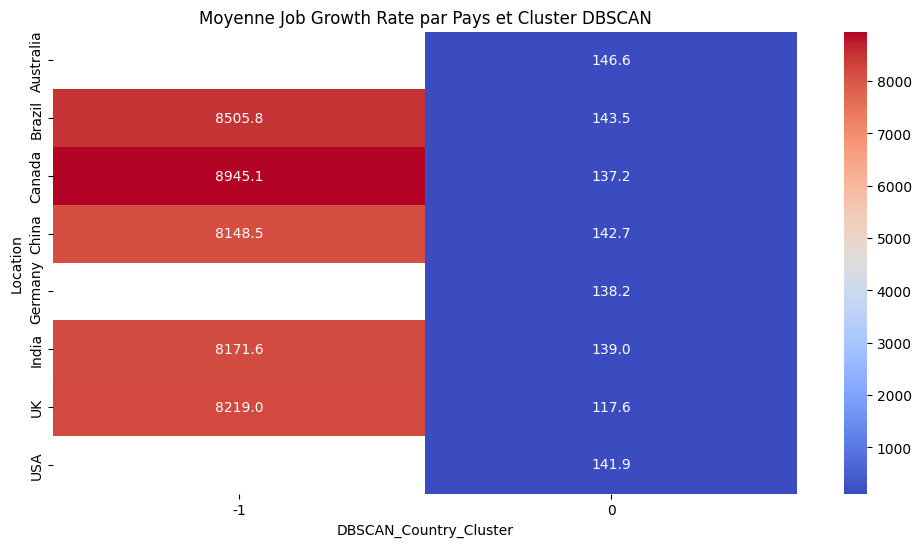

In [151]:
heatmap_data = df_fe.pivot_table(
    index='Location',
    columns='DBSCAN_Country_Cluster',
    values='Job_Growth_Rate_%',
    aggfunc='mean'
)

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Moyenne Job Growth Rate par Pays et Cluster DBSCAN')
plt.show()


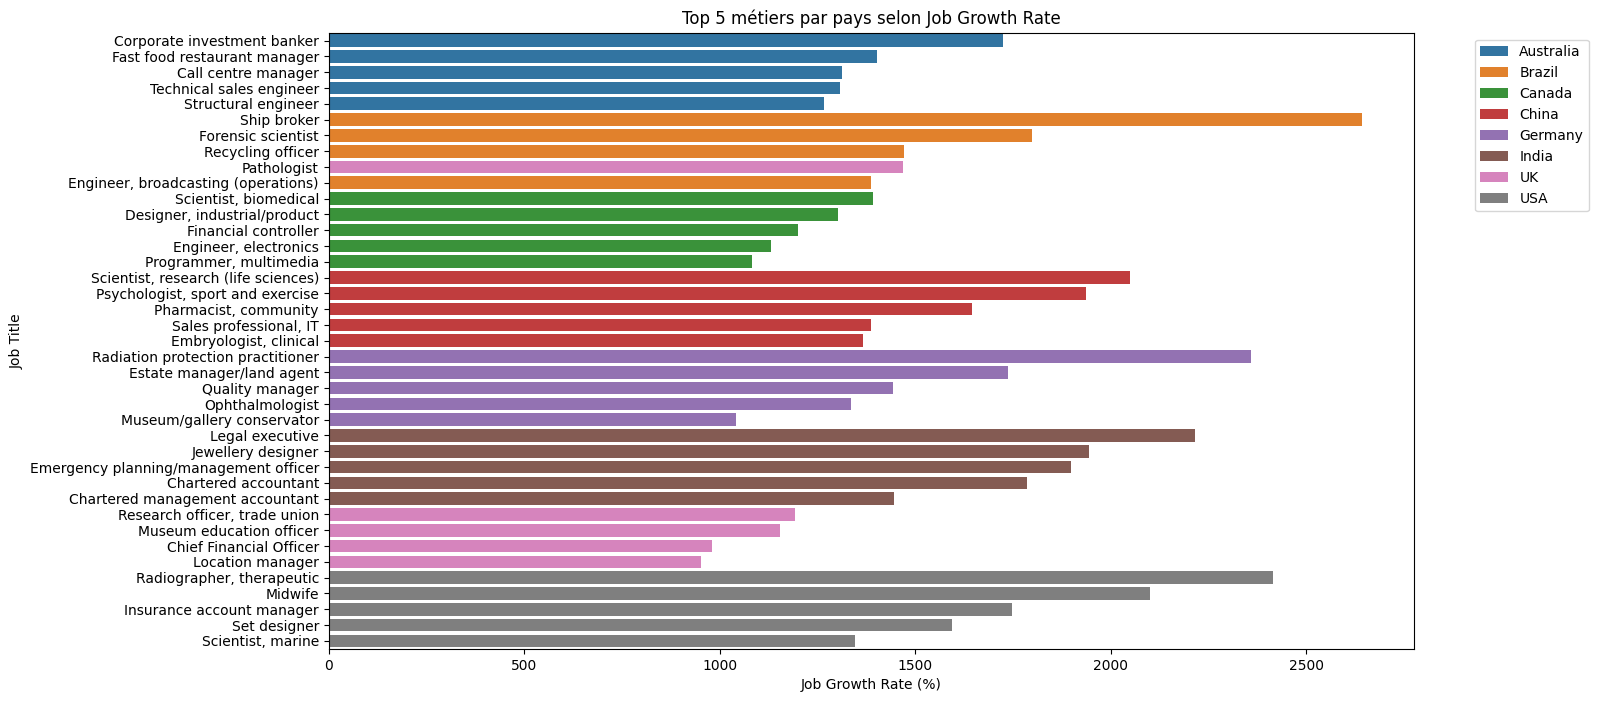

In [152]:
# Top 5 métiers par pays selon Job_Growth_Rate_%
top_jobs = df_fe.groupby(['Location','Job_Title'])['Job_Growth_Rate_%'].mean().reset_index()
top_jobs_sorted = top_jobs.sort_values(['Location','Job_Growth_Rate_%'], ascending=[True,False])
top5_jobs = top_jobs_sorted.groupby('Location').head(5)

plt.figure(figsize=(14,8))
sns.barplot(
    x='Job_Growth_Rate_%',
    y='Job_Title',
    hue='Location',
    data=top5_jobs,
    dodge=False
)
plt.title('Top 5 métiers par pays selon Job Growth Rate')
plt.xlabel('Job Growth Rate (%)')
plt.ylabel('Job Title')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


In [153]:
# Moyennes par pays et cluster DBSCAN
country_cluster_summary = df_fe.groupby(['Location', 'DBSCAN_Country_Cluster'])[
    ['Job_Growth_Rate_%', 'Automation_Risk_%', 'Median_Salary_USD', 'Experience_Required_Years']
].mean().round(2)

print(country_cluster_summary)


                                  Job_Growth_Rate_%  Automation_Risk_%  \
Location  DBSCAN_Country_Cluster                                         
Australia  0                                 146.63              50.30   
Brazil    -1                                8505.77              26.20   
           0                                 143.52              50.12   
Canada    -1                                8945.10               8.34   
           0                                 137.15              50.24   
China     -1                                8148.51              43.23   
           0                                 142.72              49.85   
Germany    0                                 138.21              50.00   
India     -1                                8171.63              86.90   
           0                                 138.96              49.99   
UK        -1                                8219.00              95.67   
           0                          

In [154]:
# Métiers à forte croissance par pays
high_growth = df_fe[df_fe['Job_Growth_Rate_%'] > df_fe['Job_Growth_Rate_%'].quantile(0.9)]
high_growth.groupby('Location')['Job_Title'].value_counts().head(10)

# Métiers à forte décroissance par pays
low_growth = df_fe[df_fe['Job_Growth_Rate_%'] < df_fe['Job_Growth_Rate_%'].quantile(0.1)]
low_growth.groupby('Location')['Job_Title'].value_counts().head(10)


Location   Job_Title                          
Australia  Careers adviser                        4
           Higher education lecturer              4
           Museum/gallery curator                 4
           Psychologist, occupational             4
           Translator                             4
           Advice worker                          3
           Ergonomist                             3
           Exhibitions officer, museum/gallery    3
           Field seismologist                     3
           Geneticist, molecular                  3
Name: count, dtype: int64

In [155]:
top_jobs_by_country = df_fe.groupby(['Location', 'DBSCAN_Country_Cluster'])['Job_Title'] \
                            .value_counts() \
                            .groupby(level=0, group_keys=False) \
                            .head(5)

print(top_jobs_by_country)


Location   DBSCAN_Country_Cluster  Job_Title                                       
Australia   0                      Administrator, sports                               15
                                   Information officer                                 14
                                   Print production planner                            14
                                   Psychotherapist, child                              13
                                   Actuary                                             12
Brazil     -1                      Advice worker                                        1
            0                      Hotel manager                                       14
                                   Insurance broker                                    14
                                   Architectural technologist                          13
                                   Child psychotherapist                               13
Canada     -1   

In [156]:
country_cluster_summary = df_fe.groupby(['Location', 'DBSCAN_Country_Cluster'])[
    ['Job_Growth_Rate_%', 'Automation_Risk_%', 'Median_Salary_USD']
].mean().round(2)

print(country_cluster_summary)


                                  Job_Growth_Rate_%  Automation_Risk_%  \
Location  DBSCAN_Country_Cluster                                         
Australia  0                                 146.63              50.30   
Brazil    -1                                8505.77              26.20   
           0                                 143.52              50.12   
Canada    -1                                8945.10               8.34   
           0                                 137.15              50.24   
China     -1                                8148.51              43.23   
           0                                 142.72              49.85   
Germany    0                                 138.21              50.00   
India     -1                                8171.63              86.90   
           0                                 138.96              49.99   
UK        -1                                8219.00              95.67   
           0                          

In [157]:
for country in df_fe['Location'].unique():
    print(f"=== {country} ===")
    for cluster in df_fe['DBSCAN_Country_Cluster'].unique():
        subset = df_fe[(df_fe['Location']==country) & (df_fe['DBSCAN_Country_Cluster']==cluster)]
        if len(subset) == 0:
            continue
        top_jobs = [str(job) for job in subset['Job_Title'].value_counts().head(5).index.tolist()]
        mean_growth = subset['Job_Growth_Rate_%'].mean().round(2)
        mean_salary = subset['Median_Salary_USD'].mean().round(2)
        mean_risk = subset['Automation_Risk_%'].mean().round(2)
        print(f"Cluster {cluster}:")
        print(f"  Croissance moyenne : {mean_growth}%")
        print(f"  Salaire moyen : {mean_salary} USD")
        print(f"  Risque d'automatisation : {mean_risk}%")
        print(f"  Métiers principaux : {', '.join(top_jobs)}")
        print(f"  Interprétation : ...\n")


=== UK ===
Cluster 0:
  Croissance moyenne : 117.61%
  Salaire moyen : 90335.88 USD
  Risque d'automatisation : 50.26%
  Métiers principaux : Surveyor, insurance, Therapist, sports, Designer, television/film set, Herpetologist, Psychiatric nurse
  Interprétation : ...

Cluster -1:
  Croissance moyenne : 8219.0%
  Salaire moyen : 116298.84 USD
  Risque d'automatisation : 95.67%
  Métiers principaux : Administrator
  Interprétation : ...

=== USA ===
Cluster 0:
  Croissance moyenne : 141.9%
  Salaire moyen : 90438.5 USD
  Risque d'automatisation : 50.44%
  Métiers principaux : Surveyor, insurance, Air traffic controller, Hydrogeologist, Surveyor, land/geomatics, Educational psychologist
  Interprétation : ...

=== Canada ===
Cluster 0:
  Croissance moyenne : 137.15%
  Salaire moyen : 89712.7 USD
  Risque d'automatisation : 50.24%
  Métiers principaux : Scientist, physiological, Water engineer, Curator, Facilities manager, Environmental health practitioner
  Interprétation : ...

Cluster 

**K_MEANS** 

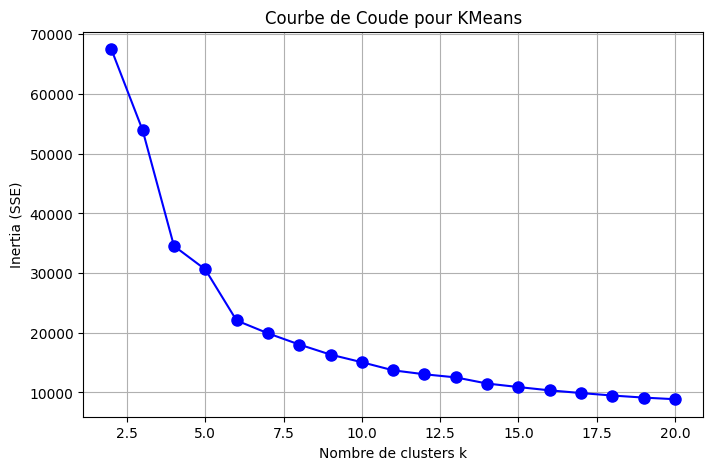

In [158]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Essai de plusieurs k
inertia = []
K_range = range(2, 21)  # tester k de 2 à 20

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Visualisation de la courbe de coude
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel("Nombre de clusters k")
plt.ylabel("Inertia (SSE)")
plt.title("Courbe de Coude pour KMeans")
plt.grid(True)
plt.show()


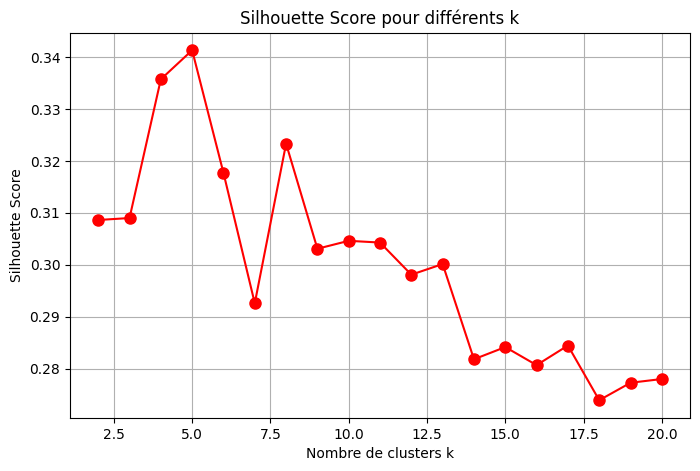

Meilleur k selon Silhouette Score : 5


In [159]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

sil_scores = []
for k in K_range:
    labels = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=512).fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels, sample_size=2000, random_state=42)
    sil_scores.append(score)


plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, 'ro-', markersize=8)
plt.xlabel("Nombre de clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score pour différents k")
plt.grid(True)
plt.show()

best_k = K_range[sil_scores.index(max(sil_scores))]
print("Meilleur k selon Silhouette Score :", best_k)


In [160]:

kmeans = KMeans(n_clusters=best_k, random_state=42)
df_fe['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)


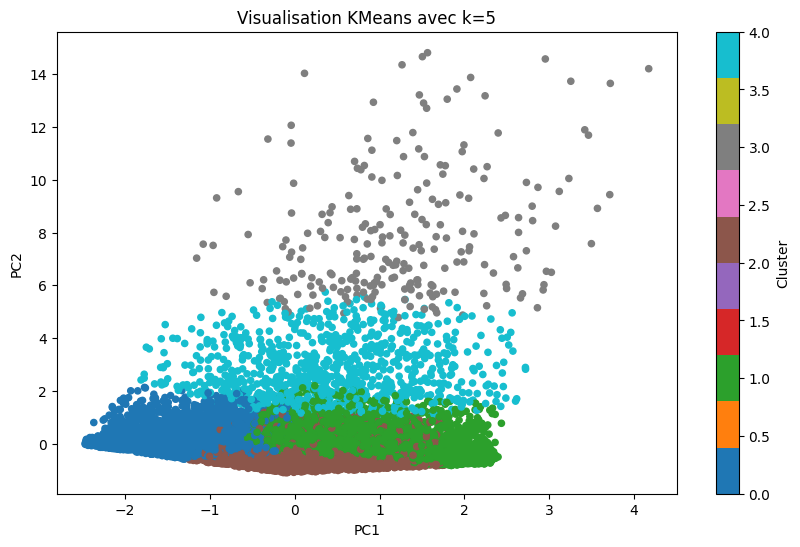

In [161]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_fe['KMeans_Cluster'], cmap='tab10', s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Visualisation KMeans avec k={best_k}")
plt.colorbar(label="Cluster")
plt.show()


In [162]:
for country in df_fe['Location'].unique():
    print(f"=== {country} ===")
    for cluster in df_fe['KMeans_Cluster'].unique():
        subset = df_fe[(df_fe['Location'] == country) & (df_fe['KMeans_Cluster'] == cluster)]
        if len(subset) == 0:
            continue
        # Top 5 métiers du cluster
        top_jobs = [str(job) for job in subset['Job_Title'].value_counts().head(5).index.tolist()]
        # Moyennes des indicateurs
        mean_growth = subset['Job_Growth_Rate_%'].mean().round(2)
        mean_salary = subset['Median_Salary_USD'].mean().round(2)
        mean_risk = subset['Automation_Risk_%'].mean().round(2)
        
        # Affichage
        print(f"Cluster {cluster}:")
        print(f"  Croissance moyenne : {mean_growth}%")
        print(f"  Salaire moyen : {mean_salary} USD")
        print(f"  Risque d'automatisation : {mean_risk}%")
        print(f"  Métiers principaux : {', '.join(top_jobs)}")
        print(f"  Interprétation : ...\n")


=== UK ===
Cluster 0:
  Croissance moyenne : 50.42%
  Salaire moyen : 58882.12 USD
  Risque d'automatisation : 31.76%
  Métiers principaux : Therapist, sports, Surveyor, insurance, Gaffer, Solicitor, Scotland, Food technologist
  Interprétation : ...

Cluster 1:
  Croissance moyenne : 55.97%
  Salaire moyen : 89595.03 USD
  Risque d'automatisation : 80.75%
  Métiers principaux : Health and safety adviser, Biomedical scientist, Fish farm manager, Maintenance engineer, Quarry manager
  Interprétation : ...

Cluster 2:
  Croissance moyenne : 45.93%
  Salaire moyen : 121836.54 USD
  Risque d'automatisation : 31.83%
  Métiers principaux : Chemical engineer, Media planner, Occupational hygienist, Engineer, biomedical, Herpetologist
  Interprétation : ...

Cluster 4:
  Croissance moyenne : 1743.11%
  Salaire moyen : 92291.94 USD
  Risque d'automatisation : 55.63%
  Métiers principaux : Event organiser, Minerals surveyor, Location manager, Actuary, Data processing manager
  Interprétation : ..

# comparaison 

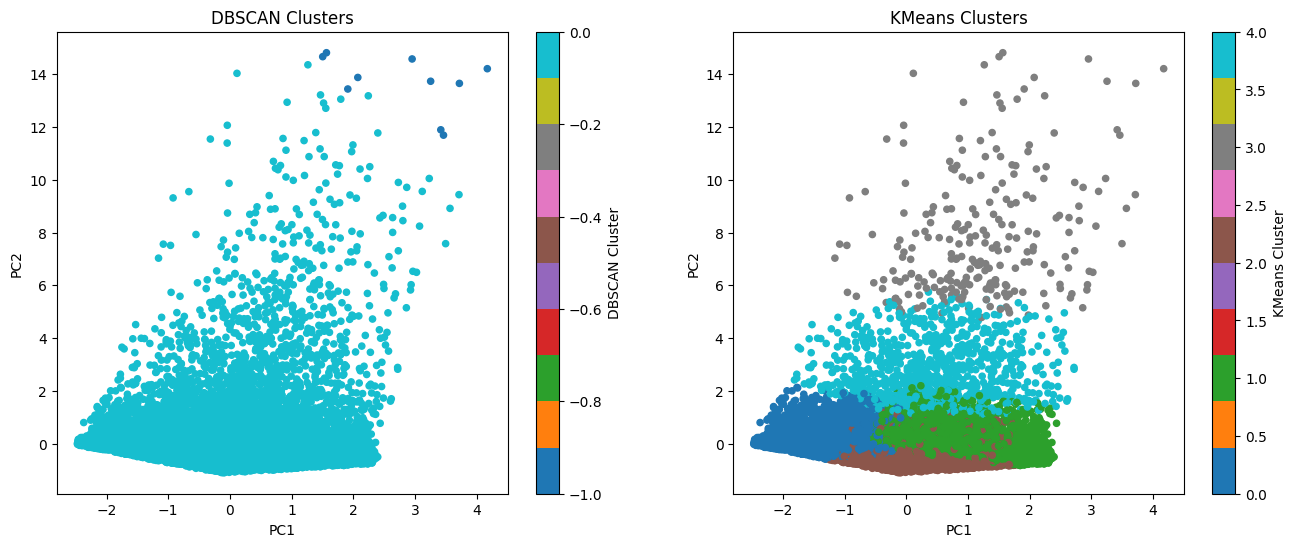

In [163]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# ---- DBSCAN ----
scatter = axes[0].scatter(X_pca[:,0], X_pca[:,1], 
                          c=df_fe['DBSCAN_Country_Cluster'], cmap='tab10', s=20)
axes[0].set_title("DBSCAN Clusters")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
fig.colorbar(scatter, ax=axes[0], label='DBSCAN Cluster')

# ---- KMeans ----
scatter2 = axes[1].scatter(X_pca[:,0], X_pca[:,1], 
                           c=df_fe['KMeans_Cluster'], cmap='tab10', s=20)
axes[1].set_title("KMeans Clusters")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
fig.colorbar(scatter2, ax=axes[1], label='KMeans Cluster')

plt.show()


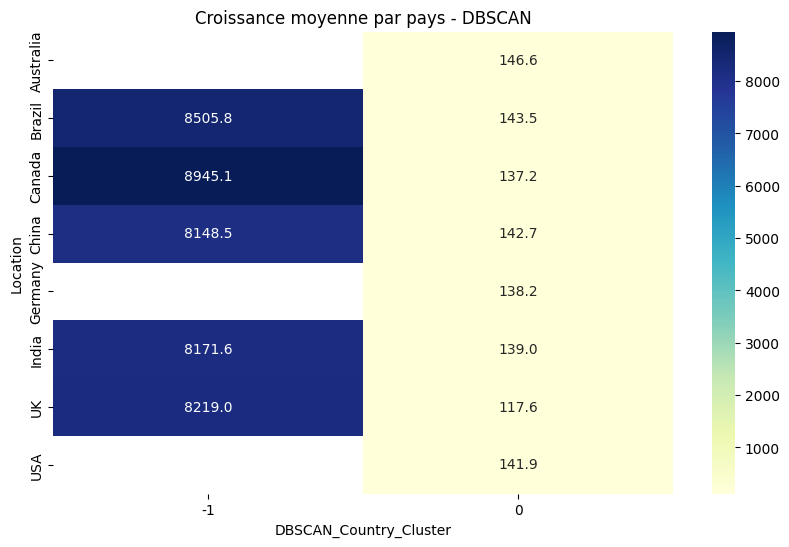

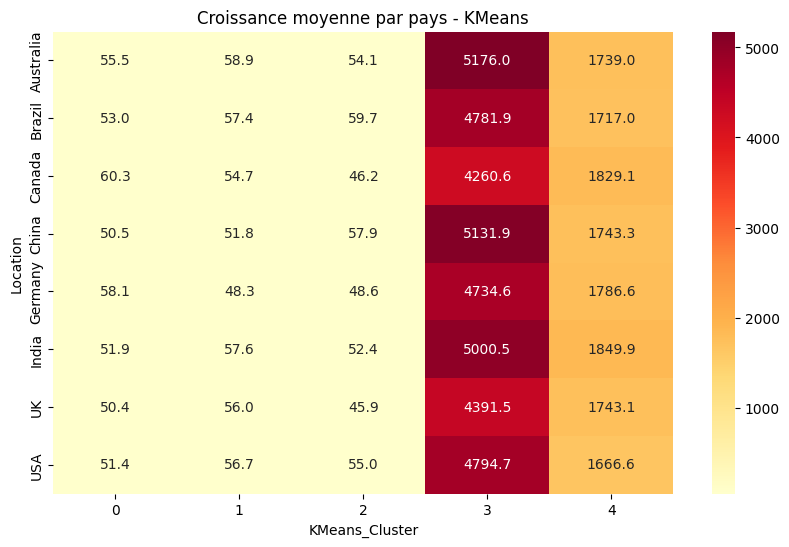

In [164]:
import seaborn as sns

# Exemple pour DBSCAN
heatmap_db = df_fe.groupby(['Location','DBSCAN_Country_Cluster'])['Job_Growth_Rate_%'].mean().unstack()
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_db, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Croissance moyenne par pays - DBSCAN")
plt.show()

# Exemple pour KMeans
heatmap_km = df_fe.groupby(['Location','KMeans_Cluster'])['Job_Growth_Rate_%'].mean().unstack()
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_km, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Croissance moyenne par pays - KMeans")
plt.show()


In [165]:
top_jobs_km = df_fe.groupby('KMeans_Cluster')['Job_Title'].apply(lambda x: x.value_counts().head(3).index.tolist())
top_jobs_db = df_fe.groupby('DBSCAN_Country_Cluster')['Job_Title'].apply(lambda x: x.value_counts().head(3).index.tolist())

print("Top métiers KMeans par cluster:\n", top_jobs_km)
print("Top métiers DBSCAN par cluster:\n", top_jobs_db)


Top métiers KMeans par cluster:
 KMeans_Cluster
0    [Air traffic controller, Insurance claims hand...
1    [Audiological scientist, Tax inspector, Osteop...
2    [Counselling psychologist, Administrator, Civi...
3    [Pathologist, Research officer, trade union, M...
4    [Librarian, public, Engineer, broadcasting (op...
Name: Job_Title, dtype: object
Top métiers DBSCAN par cluster:
 DBSCAN_Country_Cluster
-1    [Customer service manager, Psychologist, sport...
 0    [Surveyor, insurance, Counselling psychologist...
Name: Job_Title, dtype: object


> un seul graphique combiné “DBSCAN vs KMeans” où tu vois pays, croissance et clusters ensemble

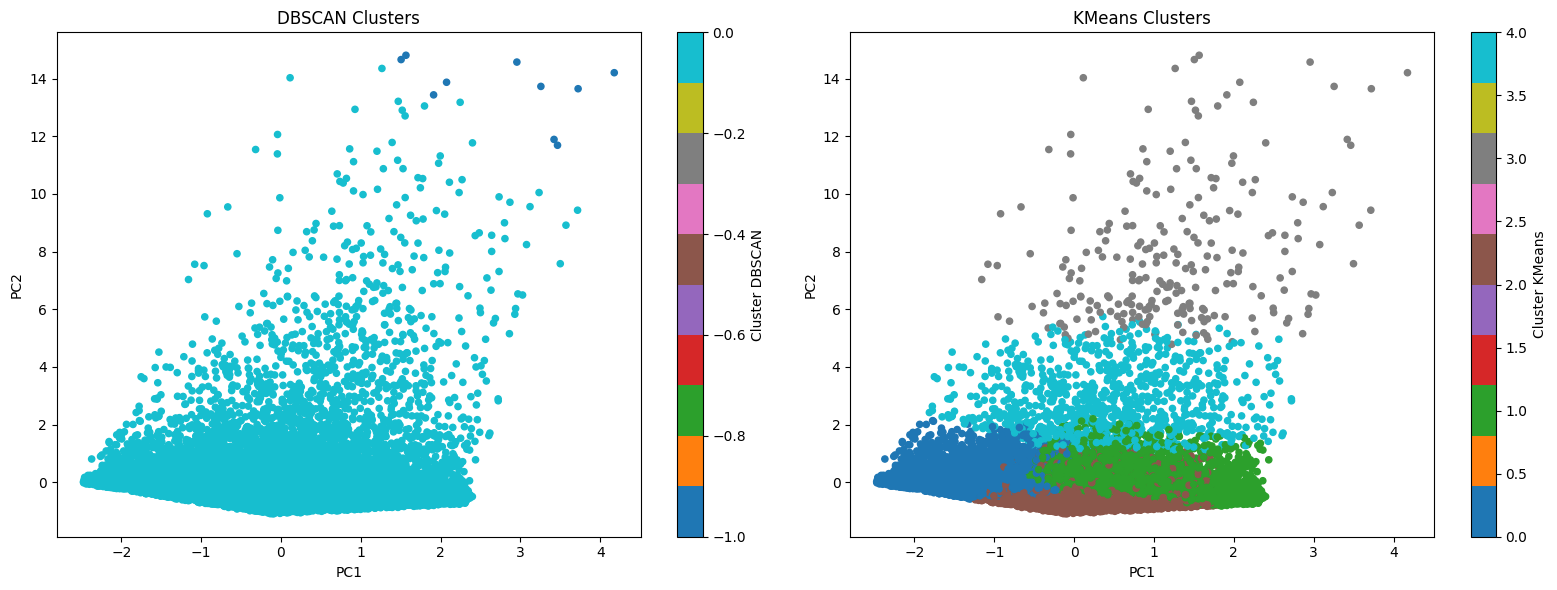

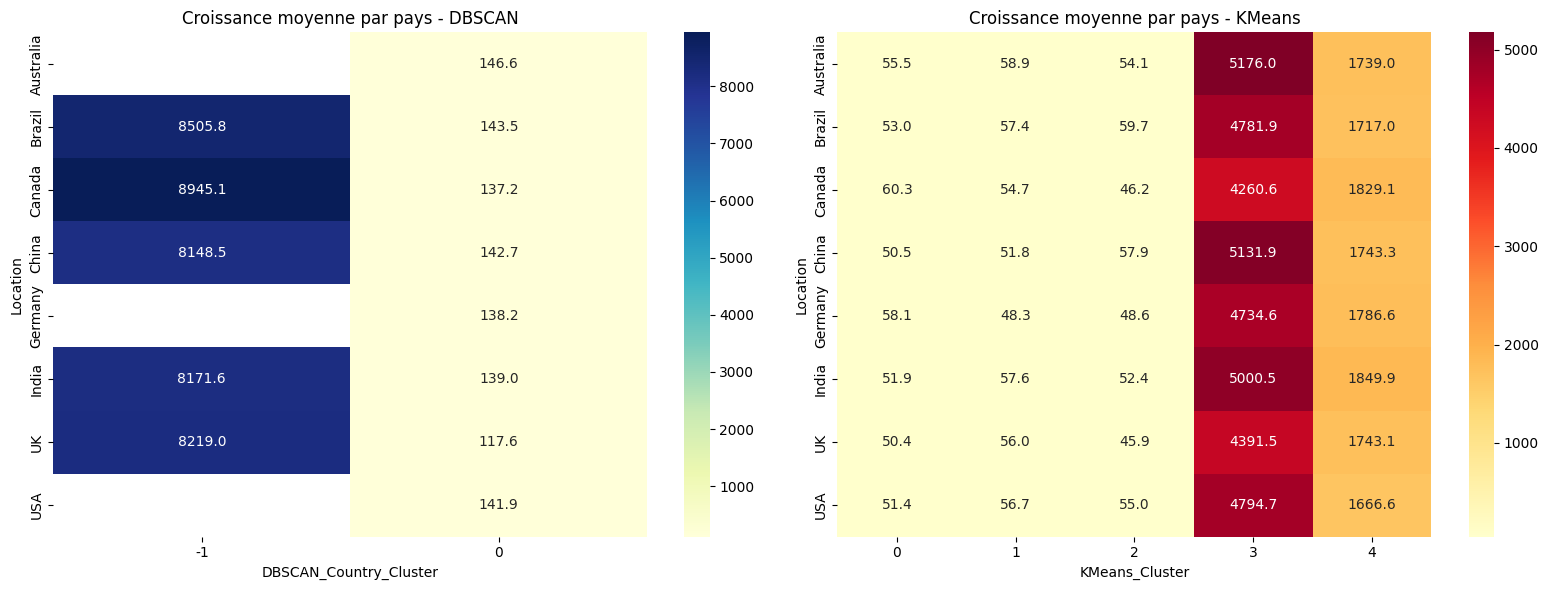

=== Top métiers DBSCAN par cluster ===
Cluster 0: ['Surveyor, insurance', 'Counselling psychologist', 'Charity officer', 'Surveyor, land/geomatics', 'Hydrogeologist']
Cluster -1: ['Customer service manager', 'Psychologist, sport and exercise', 'Advice worker', 'Jewellery designer', 'Paramedic']

=== Top métiers KMeans par cluster ===
Cluster 0: ['Air traffic controller', 'Insurance claims handler', 'Midwife', 'Surveyor, land/geomatics', 'Engineering geologist']
Cluster 1: ['Audiological scientist', 'Tax inspector', 'Osteopath', 'Surveyor, insurance', 'Recruitment consultant']
Cluster 2: ['Counselling psychologist', 'Administrator, Civil Service', 'Air cabin crew', 'Scientific laboratory technician', 'Designer, television/film set']
Cluster 4: ['Librarian, public', 'Engineer, broadcasting (operations)', 'Glass blower/designer', 'Theatre manager', 'Designer, interior/spatial']
Cluster 3: ['Pathologist', 'Research officer, trade union', 'Music tutor', 'Garment/textile technologist', 'Wate

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# PCA 2D pour réduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# ----------------- Figure 1 : Scatter PCA -----------------
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# DBSCAN
scatter1 = axes[0].scatter(X_pca[:,0], X_pca[:,1], 
                           c=df_fe['DBSCAN_Country_Cluster'], cmap='tab10', s=20)
axes[0].set_title("DBSCAN Clusters")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
fig.colorbar(scatter1, ax=axes[0], label='Cluster DBSCAN')

# KMeans
scatter2 = axes[1].scatter(X_pca[:,0], X_pca[:,1], 
                           c=df_fe['KMeans_Cluster'], cmap='tab10', s=20)
axes[1].set_title("KMeans Clusters")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
fig.colorbar(scatter2, ax=axes[1], label='Cluster KMeans')

plt.tight_layout()
plt.show()

# ----------------- Figure 2 : Heatmap croissance moyenne par pays -----------------
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# DBSCAN
heatmap_db = df_fe.groupby(['Location','DBSCAN_Country_Cluster'])['Job_Growth_Rate_%'].mean().unstack()
sns.heatmap(heatmap_db, annot=True, fmt=".1f", cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Croissance moyenne par pays - DBSCAN")

# KMeans
heatmap_km = df_fe.groupby(['Location','KMeans_Cluster'])['Job_Growth_Rate_%'].mean().unstack()
sns.heatmap(heatmap_km, annot=True, fmt=".1f", cmap="YlOrRd", ax=axes[1])
axes[1].set_title("Croissance moyenne par pays - KMeans")

plt.tight_layout()
plt.show()

# ----------------- Figure 3 : Top métiers par cluster -----------------
print("=== Top métiers DBSCAN par cluster ===")
for cluster in df_fe['DBSCAN_Country_Cluster'].unique():
    top_jobs = df_fe[df_fe['DBSCAN_Country_Cluster']==cluster]['Job_Title'].value_counts().head(5)
    print(f"Cluster {cluster}: {top_jobs.index.tolist()}")

print("\n=== Top métiers KMeans par cluster ===")
for cluster in df_fe['KMeans_Cluster'].unique():
    top_jobs = df_fe[df_fe['KMeans_Cluster']==cluster]['Job_Title'].value_counts().head(5)
    print(f"Cluster {cluster}: {top_jobs.index.tolist()}")


# CAH 

In [167]:
# check required columns exist
required = ['Location', 'Job_Title', 'Job_Growth_Rate_%']
missing = [c for c in required if c not in df_fe.columns]
if missing:
    raise KeyError(f"Missing required columns in eng_data.csv: {missing}")
# 
pivot_df = df_fe.pivot_table(
    values='Job_Growth_Rate_%',
    index='Location',
    columns='Job_Title',
    aggfunc='mean'
).fillna(0)

print(f"Pivot matrix shape (locations x jobs): {pivot_df.shape}")
non_zero_elements = (pivot_df != 0).sum().sum()
total_elements = pivot_df.shape[0] * pivot_df.shape[1]
print(f"Density: {non_zero_elements}/{total_elements} = {non_zero_elements/total_elements:.2%}")

#  Standardize rows (countries) for hierarchical clustering
scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot_df.values)   
print(f"Scaled data mean: {pivot_scaled.mean():.3f}, std: {pivot_scaled.std():.3f}")
print(f"Pays analysés : {pivot_df.index.tolist()}")


Pivot matrix shape (locations x jobs): (8, 639)
Density: 5100/5112 = 99.77%
Scaled data mean: -0.000, std: 1.000
Pays analysés : ['Australia', 'Brazil', 'Canada', 'China', 'Germany', 'India', 'UK', 'USA']


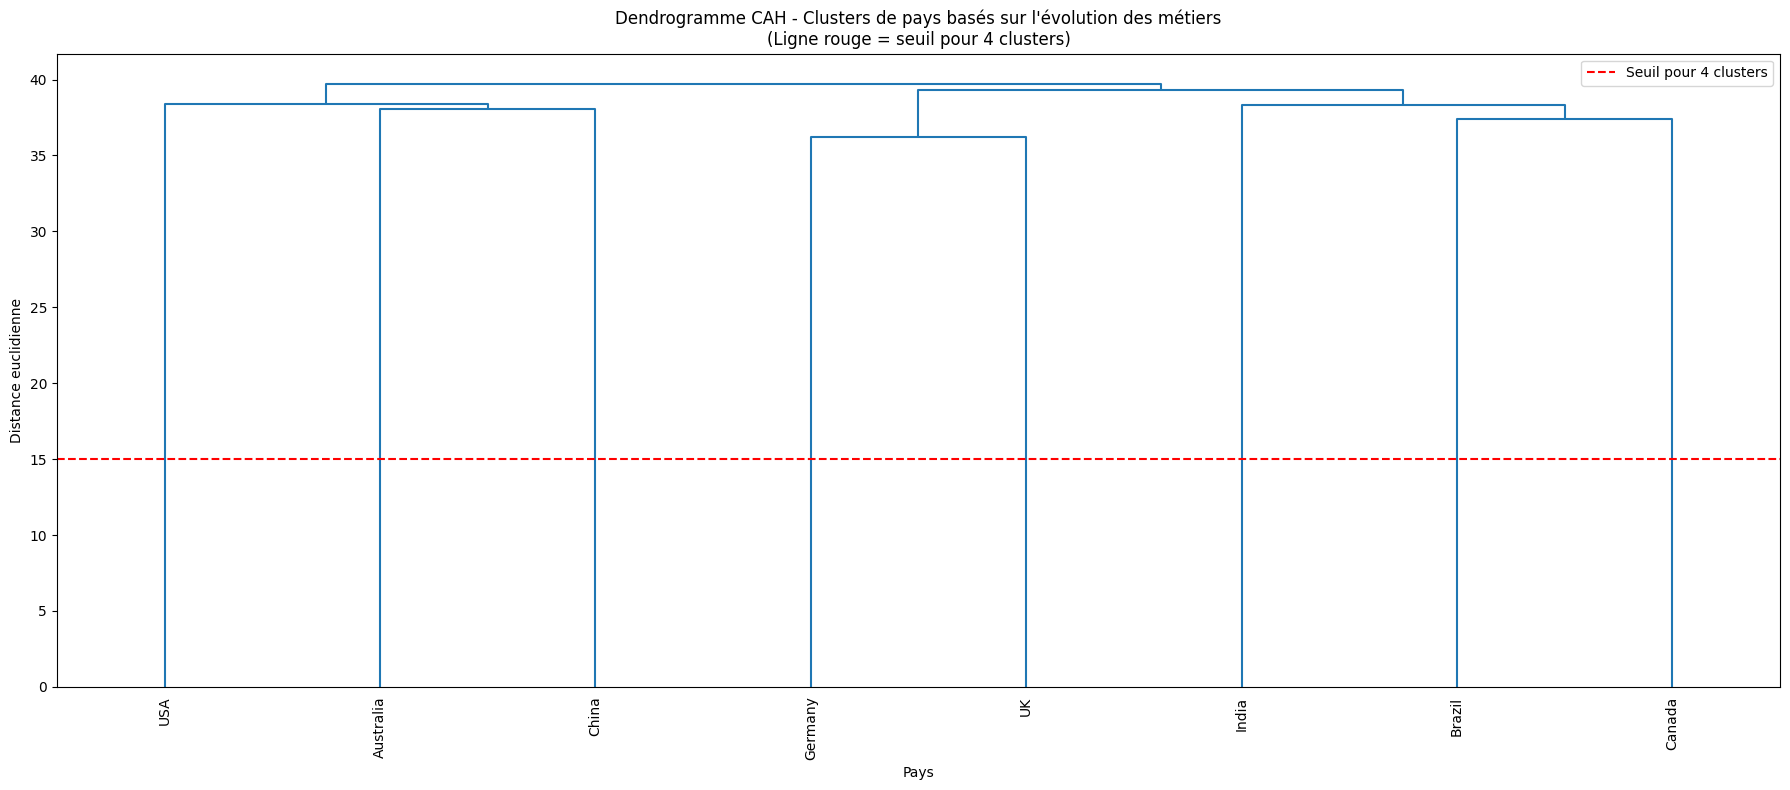

In [168]:
# Méthode 1: CAH avec scipy (pour le dendrogramme)
Z = linkage(pivot_scaled, method='ward', metric='euclidean')

# Visualisation du dendrogramme pour choisir le nombre de clusters
plt.figure(figsize=(18, 8))
dendrogram(Z,
          labels=pivot_df.index.tolist(),
          leaf_rotation=90,
          leaf_font_size=10,
          color_threshold=15)
plt.title('Dendrogramme CAH - Clusters de pays basés sur l\'évolution des métiers\n(Ligne rouge = seuil pour 4 clusters)')
plt.axhline(y=15, color='r', linestyle='--', label='Seuil pour 4 clusters')
plt.ylabel('Distance euclidienne')
plt.xlabel('Pays')
plt.legend()
plt.tight_layout()
plt.show()

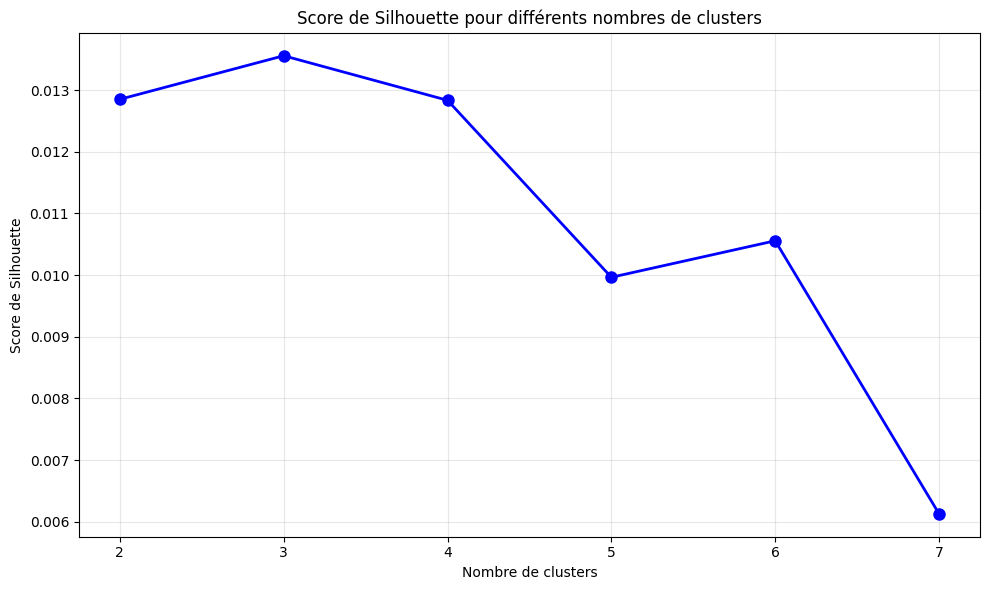

In [169]:
# Calcul du score de silhouette pour différents nombres de clusters
silhouette_scores = []
cluster_range = range(2, min(8, len(pivot_df)))  # Éviter plus de clusters que de pays

for n_clusters in cluster_range:
    # Méthode 2: CAH avec scikit-learn (plus moderne)
    hc = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='euclidean',
        linkage='ward'
    )
    cluster_labels = hc.fit_predict(pivot_scaled)

    if len(set(cluster_labels)) > 1:  # Éviter erreur si un seul cluster
        score = silhouette_score(pivot_scaled, cluster_labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)

# Visualisation des scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.title('Score de Silhouette pour différents nombres de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [170]:
# Choix du nombre optimal de clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Nombre optimal de clusters (selon silhouette) : {optimal_clusters}")

# Utilisation du nombre optimal ou d'une valeur fixe selon le contexte
num_clusters = optimal_clusters  # Vous pouvez aussi utiliser une valeur fixe comme 4


Nombre optimal de clusters (selon silhouette) : 3


In [171]:
# Application de la CAH avec le nombre choisi de clusters
hc_final = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric='euclidean',
    linkage='ward'
)
clusters = hc_final.fit_predict(pivot_scaled)

# Ajouter les clusters au DataFrame
pivot_df['Cluster'] = clusters

print(f"\nRÉPARTITION DES PAYS PAR CLUSTER ")
for cluster_num in range(num_clusters):
    countries_in_cluster = pivot_df[pivot_df['Cluster'] == cluster_num].index.tolist()
    print(f"Cluster {cluster_num}: {countries_in_cluster}")



RÉPARTITION DES PAYS PAR CLUSTER 
Cluster 0: ['Australia', 'China', 'USA']
Cluster 1: ['Brazil', 'Canada', 'India']
Cluster 2: ['Germany', 'UK']


In [172]:
hc_final = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric='euclidean',
    linkage='ward'
)
clusters = hc_final.fit_predict(pivot_scaled)
pivot_df['Cluster'] = clusters

for cluster_num in range(num_clusters):
    countries_in_cluster = pivot_df[pivot_df['Cluster'] == cluster_num].index.tolist()
    print(f"Cluster {cluster_num}: {countries_in_cluster}")

def analyze_cluster_variations(cluster_matrix, cluster_num):
    cluster_means = cluster_matrix.mean(axis=0).sort_values(ascending=False)
    top_increase = cluster_means.head(10)
    top_decrease = cluster_means.tail(10)
    print(f"\n--- Cluster {cluster_num} summary ---")
    print(f"Countries: {', '.join(cluster_matrix.index.tolist())}")
    print(f"Mean growth (all jobs): {cluster_means.mean():+.2f}%")
    print("\nTop increases (jobs):")
    print(top_increase.head(5))
    print("\nTop decreases (jobs):")
    print(top_decrease.head(5))
    return top_increase, top_decrease
print("\nDETAILED CLUSTER VARIATIONS")
for c in range(num_clusters):
    cluster_data = pivot_df[pivot_df['Cluster'] == c].drop(columns='Cluster')
    analyze_cluster_variations(cluster_data, c)

Cluster 0: ['Australia', 'China', 'USA']
Cluster 1: ['Brazil', 'Canada', 'India']
Cluster 2: ['Germany', 'UK']

DETAILED CLUSTER VARIATIONS

--- Cluster 0 summary ---
Countries: Australia, China, USA
Mean growth (all jobs): +145.35%

Top increases (jobs):
Job_Title
Corporate investment banker            930.615043
Fast food restaurant manager           836.918759
Midwife                                833.174353
Scientist, research (life sciences)    830.338993
Radiographer, therapeutic              825.239502
dtype: float64

Top decreases (jobs):
Job_Title
Planning and development surveyor   -14.845926
Acupuncturist                       -17.722892
Engineer, water                     -18.670559
Conference centre manager           -18.860748
Textile designer                    -22.730027
dtype: float64

--- Cluster 1 summary ---
Countries: Brazil, Canada, India
Mean growth (all jobs): +142.86%

Top increases (jobs):
Job_Title
Jewellery designer                     1289.223569
Ship brok

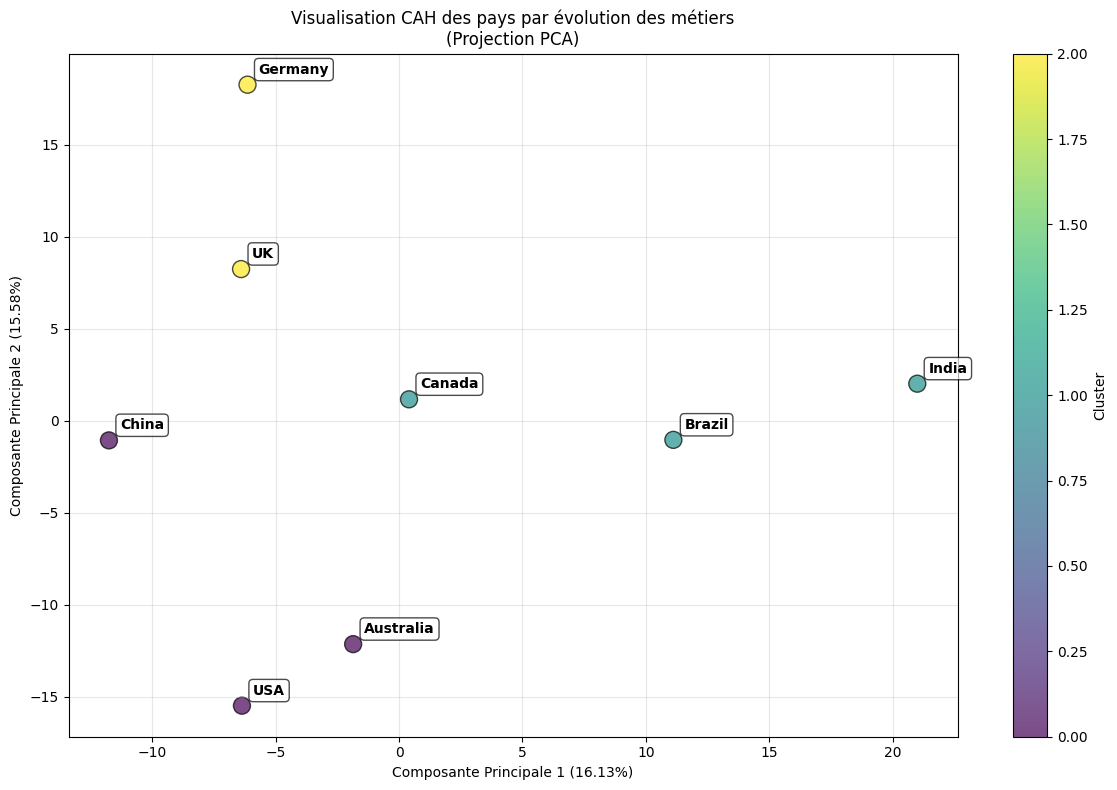

In [173]:
from sklearn.decomposition import PCA
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
pivot_pca = pca.fit_transform(pivot_scaled)

# Créer un DataFrame pour la visualisation
pca_df = pd.DataFrame({
    'PC1': pivot_pca[:, 0],
    'PC2': pivot_pca[:, 1],
    'Cluster': clusters,
    'Country': pivot_df.index
})

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'],
                     cmap='viridis', s=150, alpha=0.7, edgecolors='black')
# Ajouter les labels des pays
for i, country in enumerate(pca_df['Country']):
    plt.annotate(country, (pca_df['PC1'][i], pca_df['PC2'][i]),
                xytext=(8, 8), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

plt.colorbar(scatter, label='Cluster')
plt.title('Visualisation CAH des pays par évolution des métiers\n(Projection PCA)')
plt.xlabel(f'Composante Principale 1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Composante Principale 2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [174]:
# Calcul des statistiques globales
cluster_stats = []
for cluster_num in range(num_clusters):
    cluster_data = pivot_df[pivot_df['Cluster'] == cluster_num].drop('Cluster', axis=1)
    countries = cluster_data.index.tolist()
    mean_growth = cluster_data.values.mean()
    std_growth = cluster_data.values.std()

    cluster_stats.append({
        'Cluster': cluster_num,
        'Pays': countries,
        'Croissance Moyenne': mean_growth,
        'Variabilité': std_growth
    })

# Tri par croissance moyenne
cluster_stats_sorted = sorted(cluster_stats, key=lambda x: x['Croissance Moyenne'], reverse=True)

for i, stats in enumerate(cluster_stats_sorted, 1):
    print(f"\n{i}. Cluster {stats['Cluster']}:")
    print(f"   Pays: {', '.join(stats['Pays'])}")
    print(f"   Croissance moyenne: {stats['Croissance Moyenne']:+.1f}%")
    print(f"   Variabilité: {stats['Variabilité']:.1f}%")

# Identification des tendances globales
most_growth_cluster = cluster_stats_sorted[0]
least_growth_cluster = cluster_stats_sorted[-1]

print(f"\n CONCLUSIONS STRATÉGIQUES:")
print(f"• Le cluster le plus dynamique est le Cluster {most_growth_cluster['Cluster']} "
      f"({most_growth_cluster['Croissance Moyenne']:+.1f}%)")
print(f"• Le cluster le plus en difficulté est le Cluster {least_growth_cluster['Cluster']} "
      f"({least_growth_cluster['Croissance Moyenne']:+.1f}%)")
print(f"• Score de silhouette moyen: {silhouette_score(pivot_scaled, clusters):.3f}")

print(f"\nANALYSE TERMINÉE AVEC SUCCÈS!")
print(f"• {len(pivot_df)} pays analysés")
print(f"• {pivot_df.shape[1]-1} métiers considérés")
print(f"• {num_clusters} clusters identifiés")



1. Cluster 0:
   Pays: Australia, China, USA
   Croissance moyenne: +145.3%
   Variabilité: 253.9%

2. Cluster 1:
   Pays: Brazil, Canada, India
   Croissance moyenne: +142.9%
   Variabilité: 248.9%

3. Cluster 2:
   Pays: Germany, UK
   Croissance moyenne: +124.4%
   Variabilité: 213.4%

 CONCLUSIONS STRATÉGIQUES:
• Le cluster le plus dynamique est le Cluster 0 (+145.3%)
• Le cluster le plus en difficulté est le Cluster 2 (+124.4%)
• Score de silhouette moyen: 0.014

ANALYSE TERMINÉE AVEC SUCCÈS!
• 8 pays analysés
• 639 métiers considérés
• 3 clusters identifiés
